In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
%matplotlib inline

DOWNLOAD_PATH = 'C:\\Users\\rusfrl\\Downloads'
events_data = pd.read_csv(os.path.join(DOWNLOAD_PATH, 'event_data_train.csv'))
submissions_data = pd.read_csv(os.path.join(
    DOWNLOAD_PATH, 'submissions_data_train.csv'))

SyntaxError: invalid syntax (<ipython-input-1-0b3d37e22cd3>, line 7)

In [58]:
events_data['date'] = pd.to_datetime(events_data.timestamp, unit='s')
events_data['day'] = events_data.date.dt.date
events_data.head()

,step_id,timestamp,action,user_id,date,day
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15


In [59]:
submissions_data['date'] = pd.to_datetime(submissions_data.timestamp, unit='s')
submissions_data['day'] = submissions_data.date.dt.date
submissions_data.head()

,step_id,timestamp,submission_status,user_id,date,day
0,31971,1434349275,correct,15853,2015-06-15 06:21:15,2015-06-15
1,31972,1434348300,correct,15853,2015-06-15 06:05:00,2015-06-15
2,31972,1478852149,wrong,15853,2016-11-11 08:15:49,2016-11-11
3,31972,1478852164,correct,15853,2016-11-11 08:16:04,2016-11-11
4,31976,1434348123,wrong,15853,2015-06-15 06:02:03,2015-06-15


In [60]:
gap_event = events_data[['user_id','day', 'timestamp']].drop_duplicates(subset=['day']) \
    .groupby('user_id')['timestamp'].apply(list) \
    .apply(np.diff).values
gap_event = pd.Series(np.concatenate(gap_event, axis=0))

In [61]:
gap_event.quantile(0.95)/ (24*60*60)

59.60039351851843

In [72]:
now = 1526772811
drop_threshold = 30 * (24*60*60)
learning_time_threshold = 3 * (24*60*60)

In [63]:
users_events = events_data.pivot_table(index='user_id',
                       columns='action',
                       values='step_id',
                       aggfunc='count',
                       fill_value=0).reset_index()
users_events.head()

action,user_id,discovered,passed,started_attempt,viewed
0,1,1,0,0,1
1,2,9,9,2,10
2,3,91,87,30,192
3,5,11,11,4,12
4,7,1,1,0,1


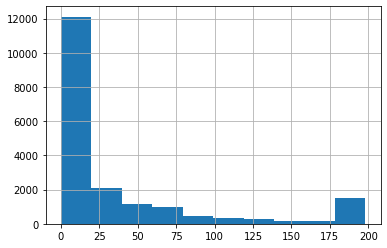

In [64]:
users_events.discovered.hist()

In [65]:
users_scores = submissions_data.pivot_table(index='user_id',
                       columns='submission_status',
                       values='step_id',
                       aggfunc='count',
                       fill_value=0).reset_index()
users_scores.head()

submission_status,user_id,correct,wrong
0,2,2,0
1,3,29,23
2,5,2,2
3,8,9,21
4,14,0,1


In [67]:
users_data = events_data.groupby('user_id', as_index=False) \
                    .agg({'timestamp':'max'}) \
                    .rename(columns={'timestamp':'last_timestamp'})
user_min_time = events_data.groupby('user_id',as_index=False) \
                        .agg({'timestamp':'min'}) \
                        .rename({'timestamp':'min_timestamp'}, axis=1)
users_data['is_gone'] = (now-users_data.last_timestamp) > drop_threshold
users_data.head()

,user_id,last_timestamp,is_gone
0,1,1472827464,True
1,2,1519226966,True
2,3,1444581588,True
3,5,1499859939,True
4,7,1521634660,True


In [68]:
users_days = events_data.groupby('user_id').day.nunique().to_frame().reset_index()
users_days.head()

,user_id,day
0,1,1
1,2,2
2,3,7
3,5,2
4,7,1


In [69]:
users_data = users_data.merge(users_scores, on='user_id', how='outer')
users_data = users_data.merge(users_events, on='user_id', how='outer')
users_data = users_data.merge(users_days, on='user_id', how='outer')
users_data = users_data.merge(user_min_time, on='user_id', how='outer')
users_data = users_data.fillna(0)
users_data.head()

,user_id,last_timestamp,is_gone,correct,wrong,discovered,passed,started_attempt,viewed,day,min_timestamp
0,1,1472827464,True,0.0,0.0,1,0,0,1,1,1472827464
1,2,1519226966,True,2.0,0.0,9,9,2,10,2,1514383364
2,3,1444581588,True,29.0,23.0,91,87,30,192,7,1434358476
3,5,1499859939,True,2.0,2.0,11,11,4,12,2,1466156809
4,7,1521634660,True,0.0,0.0,1,1,0,1,1,1521634660


In [71]:
users_data['passed_course'] = users_data.passed > 170
users_data.head()

,user_id,last_timestamp,is_gone,correct,wrong,discovered,passed,started_attempt,viewed,day,min_timestamp,passed_course
0,1,1472827464,True,0.0,0.0,1,0,0,1,1,1472827464,False
1,2,1519226966,True,2.0,0.0,9,9,2,10,2,1514383364,False
2,3,1444581588,True,29.0,23.0,91,87,30,192,7,1434358476,False
3,5,1499859939,True,2.0,2.0,11,11,4,12,2,1466156809,False
4,7,1521634660,True,0.0,0.0,1,1,0,1,1,1521634660,False


In [75]:
events_data['user_time'] = events_data.user_id.map(str) + '_' + events_data.timestamp.map(str)
user_min_time['user_learning_time_threshold'] = user_min_time.user_id.map(str)+'_'+(user_min_time.min_timestamp+learning_time_threshold).map(str)
events_data_with_threshold = events_data.merge(user_min_time[['user_id','user_learning_time_threshold']], on='user_id', how='outer')
#фишка - строки можно сравнить как числа
events_data_train = events_data_with_threshold[events_data_with_threshold.user_time <= events_data_with_threshold.user_learning_time_threshold]
events_data_train.head()

,step_id,timestamp,action,user_id,date,day,user_time,user_learning_time_threshold
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434600048
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434600048
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434600048
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15,17632_1434340895,17632_1434600048
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15,17632_1434340895,17632_1434600048
